# Import Packages

In [52]:
from ipywidgets import HTML
import ipywidgets as widgets
from ipyleaflet import Map, Polyline, Rectangle, basemaps, basemap_to_tiles, Polygon, FullScreenControl, Popup, WidgetControl
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle, FullScreenControl, LayerGroup
from ipywidgets.embed import embed_minimal_html
import sys
sys.path.append('/datc/saab/notebooks')

# Functions

In [53]:
def Sort(sub_li, fieldnum): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    return(sorted(sub_li, key = lambda x: x[fieldnum]))
def get_color_scale(arr, scale_type='plasma'):
    arr = list(arr)
    #https://matplotlib.org/gallery/color/colormap_reference.html
    scale = cm.get_cmap(scale_type, len(arr)).colors
    
    arr = np.array(arr)
    sorted_index = np.argsort(arr)
    return {arr[sorted_index[i]]:rgb_to_hex(scale[i]) for i in range(len(arr))}
def rgb_to_hex(rgb):
    if len(rgb) == 4:
        rgb = rgb[:3]
    return '#%02x%02x%02x' % tuple(list([int(elem*256) for elem in rgb]))

# Import Data

In [54]:
# Code to import the data and remove NaN values from it
filename = '/datc/saab/reduced_area_clean.h5'
data = pd.read_hdf(filename, 'df')
data = data.dropna()
data.latitude = data['latitude'] + 47.72
data.longitude = data['longitude'] + 157.85
data.head()

,mmsi,datetime,latitude,longitude,orientation,rateofturn,course,length,breadth,speed,vesseltype
171,56295,2018-11-30 16:00:00.707,22.199854,114.080508,98.0000,0.000000,89.00000,24.500000,3.099609,0.620117,0
189,0,2018-11-30 16:00:00.707,22.216311,114.091476,166.2500,0.000000,165.00000,54.812500,13.703125,3.759766,0
190,0,2018-11-30 16:00:00.707,22.191633,114.090895,275.2500,0.000000,136.37500,148.750000,19.203125,0.040009,0
191,0,2018-11-30 16:00:00.707,22.167373,114.086139,41.8125,0.000000,42.40625,57.906250,8.000000,4.019531,0
205,93,2018-11-30 16:00:00.707,22.259018,114.105921,144.7500,-3.400391,167.00000,21.296875,2.699219,0.560059,0


# Get ships sequences of data

In [55]:
CRAFT_ID_list = data.mmsi.unique()#Get the mmsi unique values into a list:
CRAFT_ID_list = CRAFT_ID_list[CRAFT_ID_list!=0]
ships_info = []
ship_number = 0
for rowid in CRAFT_ID_list:
    #Start with empty lists
    npinfo, infolist = [], []
    #Get a numpy array composed by 'latitude', 'longitude', 'orientation', 'length', 'breadth'
    npinfo = data[data.mmsi == rowid][['latitude', 'longitude', 'datetime']].values
    #Convert it to a python list so it can be an attribute of the multypoligon functionality of ipyleaflet
    infolist = list([list(coords) for coords in npinfo])
    ships_info.append(infolist)
    ship_number+=1
    if ship_number%100 == 0:
        print(ship_number, '/', len(CRAFT_ID_list))

ships_info = [Sort(row, -1) for row in ships_info]

100 / 507
200 / 507
300 / 507
400 / 507
500 / 507


In [56]:
data = data[['latitude', 'longitude']].values

In [57]:
print(data)

[[ 22.19985386 114.08050839]
 [ 22.21631077 114.09147578]
 [ 22.19163252 114.090895  ]
 ...
 [ 22.24484306 114.12569758]
 [ 22.25020148 114.13120675]
 [ 22.15808705 114.1481558 ]]


# Define the boundaries of the grid

In [58]:
decimals = 3
radius = 10**(-decimals)
data = np.round(data, decimals)
print(data)
minimum_lat = min(data[:,0])
maximum_lat = max(data[:,0])
minimum_lon = min(data[:,1])
maximum_lon = max(data[:,1])
print(minimum_lat, minimum_lon, maximum_lat, maximum_lat)

[[ 22.2   114.081]
 [ 22.216 114.091]
 [ 22.192 114.091]
 ...
 [ 22.245 114.126]
 [ 22.25  114.131]
 [ 22.158 114.148]]
22.156 114.076 22.275 22.275


Lat-lon rounded values

In [59]:
lon_coordinates = np.arange(start=np.round(minimum_lon, decimals), stop=np.round(maximum_lon, decimals), step=np.round(10**(-decimals), decimals))
lat_coordinates = np.arange(start=np.round(minimum_lat, decimals), stop=np.round(maximum_lat, decimals), step=np.round(10**(-decimals), decimals))


Size

In [60]:
print('grid size:', len(lon_coordinates), 'x', len(lat_coordinates))

grid size: 173 x 119


# Plot the grid in a measurable map

In [61]:
from ipyleaflet import Map, MeasureControl
density = {}
print(len(lon_coordinates)*len(lat_coordinates))
i=0
lat_dif = max(lat_coordinates) - min(lat_coordinates)
m = Map(center = (22.205232, 114.123882), zoom = 12)#Define the map object
for i,lat in enumerate(lat_coordinates):
    line = Polyline(
    locations = [[lat, min(lon_coordinates)], [lat, max(lon_coordinates)]],
    color = "black" ,
    weight=1,
    opacity=0.5,
    fill_color= "black")
    m.add_layer(line)
for i,lon in enumerate(lon_coordinates):
    line = Polyline(
    locations = [[min(lat_coordinates), lon], [max(lat_coordinates), lon]],
    color = "black" ,
    weight=1,
    opacity = 0.5,
    fill_color= "black")
    m.add_layer(line)
m.add_control(FullScreenControl())
measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'kilometers'
)
m.add_control(measure)
m

20587


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Obtaining density for each node

In [62]:
density = {}
print(len(lon_coordinates)*len(lat_coordinates))
i=0
for lat in lat_coordinates:
    for lon in lon_coordinates:
        if i%1000 == 0:
            print(i)
        density[(np.round(lat,decimals), np.round(lon,decimals))]=0
        i+=1
#print(density)
uniq_points, counts = np.unique(data, return_counts=True, axis=0)
uniq_points = [tuple(elem) for elem in uniq_points]
end = len(uniq_points)
for i, p in enumerate(uniq_points):
    if i%1000 ==0:
        print(i+1, ' out of ', end)
    density[p] = counts[int(i)]

20587
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
1  out of  12530
1001  out of  12530
2001  out of  12530
3001  out of  12530
4001  out of  12530
5001  out of  12530
6001  out of  12530
7001  out of  12530
8001  out of  12530
9001  out of  12530
10001  out of  12530
11001  out of  12530
12001  out of  12530


# Functions to plot maps

In [47]:
import matplotlib.pyplot as plt


def plot_map_size(densit, threshold, save=False, filename='default_filename'):
    density = {x:y for x,y in densit.items() if y>=threshold}
    plt.hist(density.values())
    plt.show()
    m = Map(center = (22.205232, 114.123882), zoom = 12)#Define the map object
    i=0
    max_density = max(density.values())
    min_density = min(density.values())
    print(len(density), ' points')
    for density_point in density.keys():
        i+=1
        rad = int((density[density_point]-min_density)/(max_density-min_density)*1000)
        circle = Circle(location = (density_point), radius = rad, color = "green", fill_color = "green")
        m.add_layer(circle)
    m.add_control(FullScreenControl())
    if save:
        embed_minimal_html(filename, views=[m])
    return m


def plot_map_color(densit, threshold, save=False, filename='default_filename'):  
    density = {x:y for x,y in densit.items() if y>=threshold}
    color_scale = get_color_scale(density.values())
    print(len(density), ' points')
    m = Map(center = (22.205232, 114.123882), zoom = 12)#Define the map object
    i=0
    max_density = max(density.values())
    min_density = min(density.values())
    for density_point in density.keys():
        rad = 10
        circle = Circle(location = (density_point), radius = rad, color = color_scale[density[density_point]], fill_color = color_scale[density[density_point]])
        m.add_layer(circle)
        i+=1
    m.add_control(FullScreenControl())
    if save:
        embed_minimal_html(filename, views=[m])
    return m
#color_map = plot_map_size(density, uniq_points, 200)
#color_map

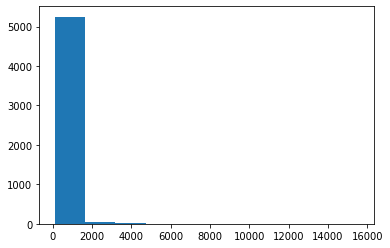

5304  points


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [48]:
plot_map_size(density, 100)

In [49]:
plot_map_color(density, 100)

5304  points


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

# Derived model from the obtained densities

In [63]:
threshold = 5


ships_info_density0 = [[] for ship in ships_info]
anomalous_points = [[] for ship in ships_info]
for i, ship in enumerate(ships_info):
    for j, point in enumerate(ship):
        d = density[tuple(np.round(point[:2], decimals))]
        ships_info_density0[i].append(d)
        if d <= threshold:
            anomalous_points[i].append(ship[j])

In [64]:
print('% of anomalous LAT,LONG positions: ', sum([len(anomaly) for anomaly in anomalous_points])/sum([len(ship) for ship in ships_info])*100)

% of anomalous LAT,LONG positions:  0.07246434515325015


In [65]:
[len(anomaly) for anomaly in anomalous_points]

[2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 7,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 1,
 3,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 11,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 13,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 3,
 0,
 0,
 3,
 5,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 4,
 0,
 18,
 0,
 0,
 0,
 0,
 6,
 0,
 7,
 0,
 0,
 0,
 0,
 14,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 1,
 8,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


# Anomalies map according to ships crossing non-frequent areas

In [66]:
m = Map(center = (22.205232, 114.123882), zoom = 12)#Define the map object

#To define  the maximum number of steps we will be able to take with the slider
max_steps = len(ships_info)
ships_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max_steps,
    step=1,
    description='Ships: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
widget_steps = WidgetControl(widget=ships_slider, position='topright')
m.add_control(widget_steps)
m.add_control(FullScreenControl())
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
m.add_layer(dark_matter_layer)
previous_value = 0


def update_map(ships_slider):
    global previous_value, m
    if previous_value > ships_slider:
        m = Map(center = (-22.884059, 133.714373), zoom =4)#Define the map object
        ini, end = 0, ships_slider
    else:
        ini, end = previous_value, ships_slider
        
        
    for i in range(ini, end):
        """plt.figure(figsize=(20,10))"""
        color_value = 'green'
        #for each time series in ships_info list --> Paint The line
        line = Polyline(
            locations = [[elem[0],elem[1]] for elem in ships_info[i]],
            color = 'green',
            fill_color= "transparent",
            weight = 2,
            opacity = 0.4)
        m.add_layer(line)
        
        
        """plt.plot([elem[-1] for j, elem in enumerate(ships_info[i])],
                 [elem for j, elem in enumerate(ships_info_density0[i])], c='green', alpha=0.7)
        
        plt.scatter([elem[-1] for j, elem in enumerate(ships_info[i]) if ships_info_density0[i][j]<threshold],
                 [elem for j, elem in enumerate(ships_info_density0[i]) if ships_info_density0[i][j]<threshold]
                 , c='red', s=20)
        plt.title('Ship Density: ')"""

        for anom_n, anomaly in enumerate(anomalous_points[i]):
            #plt.plot([elem[-1] for elem in anomaly],
            #         [elem[3] for elem in anomaly], c='red')
            circle = Circle(location = (anomaly[0], anomaly[1]), radius = 1, color = 'red', fill_color = 'red')

            m.add_layer(circle)

    """plt.show()"""
    previous_value = ships_slider
display(m)
widgets.interactive(update_map, ships_slider=ships_slider)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

interactive(children=(IntSlider(value=0, continuous_update=False, description='Ships: ', max=507), Output()), …